In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Загрузим из пакета torchvision тренировочный датасет FashionMnist
train_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                                  train=True,
                                                  download=True,
                                                  transform=torchvision.transforms.ToTensor())

In [ ]:
train_dataset.data.shape

In [4]:
# Загрузим из пакета torchvision валидационный датасет FashionMnist
test_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                                 train=False,
                                                 download=True,
                                                 transform=torchvision.transforms.ToTensor())

In [ ]:
test_dataset.data.shape

In [ ]:
# Определим количество классов для задачи классификации картинок
classes = len(set(train_dataset.targets.numpy())) # Не забываем переводить тензор PyTorch в нужный нам тип данных иначе операция не выполнится
print("Number of classes in FMNIST: {}".format(classes))

In [26]:
# Построим модель
class CNN(torch.nn.Module):
    def __init__(self, classes):
        super(CNN, self).__init__()
        # Слой операций трансформации признакового пространства при помощи операций сверток:
        self.convolutional_layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            torch.nn.ReLU()
        )
        # Полезные ссылки для рассчета формы и измерений сверток
        # https://github.com/vdumoulin/conv_arithmetic
        # Полносвязный слой отвечающий за классификатор
        self.dense_layers = torch.nn.Sequential(
            torch.nn.Dropout(),
            torch.nn.Linear(128 * 2 * 2, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(512, classes)
        )
    # Метод отвечающий за комбинацию слоёв сверточной нейронной сети и метод прямого распространения ошибки
    def forward(self, X):
        out = self.convolutional_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out


In [27]:
# инициализируем модель сверточной нейронной сети построенную выше
model = CNN(classes=classes)

In [28]:
# Перенесем все на устройство которое нам необходимо (если есть GPU переводим на GPU если нет, оставляем модель для обучения на CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
model.to(device)

CNN(
  (convolutional_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [30]:
# Зададим функцию потерь и метод градиентного спуска
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [31]:
# Создадим DataLoader для того чтобы передавать данные по батчам
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                     batch_size=batch_size,
                                     shuffle=False)

In [34]:
# Создадим функцию которая будет отвечать за обучение модельки (полезно чтобы каждый раз не писать стандартные шаги предназначенные для тренировки)
def batch_GD(model, loss, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      losses = loss(outputs, targets)
      losses.backward()
      optimizer.step()
      train_loss.append(losses.item())
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      losses = loss(outputs, targets)
      test_loss.append(losses.item())
    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}  Train Loss: {train_loss:.4f}  Test Loss: {test_loss:.4f}  Duration: {dt}')

  return train_losses, test_losses

In [35]:
train_losses, test_losses = batch_GD(
    model, loss, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.7643,       Test Loss: 0.5287, Duration: 0:00:07.567817
Epoch 2/15, Train Loss: 0.5072,       Test Loss: 0.4507, Duration: 0:00:07.119001
Epoch 3/15, Train Loss: 0.4480,       Test Loss: 0.4119, Duration: 0:00:07.086095
Epoch 4/15, Train Loss: 0.4116,       Test Loss: 0.3817, Duration: 0:00:07.052000
Epoch 5/15, Train Loss: 0.3889,       Test Loss: 0.3649, Duration: 0:00:07.210001
Epoch 6/15, Train Loss: 0.3682,       Test Loss: 0.3602, Duration: 0:00:07.179000
Epoch 7/15, Train Loss: 0.3508,       Test Loss: 0.3438, Duration: 0:00:07.117999
Epoch 8/15, Train Loss: 0.3364,       Test Loss: 0.3379, Duration: 0:00:07.165096
Epoch 9/15, Train Loss: 0.3227,       Test Loss: 0.3244, Duration: 0:00:06.869130
Epoch 10/15, Train Loss: 0.3114,       Test Loss: 0.3077, Duration: 0:00:06.821733
Epoch 11/15, Train Loss: 0.3000,       Test Loss: 0.3103, Duration: 0:00:07.134559
Epoch 12/15, Train Loss: 0.2886,       Test Loss: 0.2983, Duration: 0:00:07.023746
Epoch 13/15, 

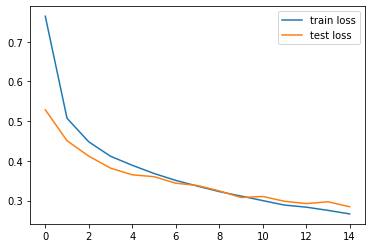

In [36]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [37]:
# Accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  # Forward pass
  outputs = model(inputs)
  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]


train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  # Forward pass
  outputs = model(inputs)
  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9227, Test acc: 0.8940


In [38]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[859   1  28  26   2   1  78   0   5   0]
 [  2 974   0  17   3   0   2   0   2   0]
 [ 13   1 833   9  77   0  66   0   1   0]
 [ 13   1  17 916  30   0  20   0   3   0]
 [  0   1  37  26 850   0  85   0   1   0]
 [  0   0   0   2   0 973   0  17   0   8]
 [121   0  79  28 104   0 658   0  10   0]
 [  0   0   0   0   0  11   0 931   0  58]
 [  1   1   6   2   5   2   3   4 976   0]
 [  1   0   0   0   0   4   0  24   1 970]]


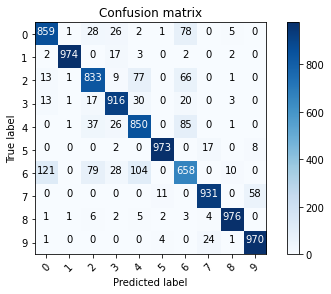

In [39]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [40]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

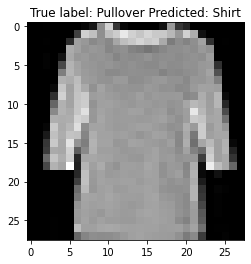

In [41]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));